In [1]:
%matplotlib inline

## for data
import numpy as np
import pandas as pd
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for math
import math

## Reading Data

In [2]:
df= pd.read_csv("/home/asma/Documents/Reza/transfusion.data")

In [3]:
df

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


In [4]:
for col in df:
    print (col, df[col].min())

Recency (months) 0
Frequency (times) 1
Monetary (c.c. blood) 250
Time (months) 2
whether he/she donated blood in March 2007 0


In [5]:
df.rename(columns = {"whether he/she donated blood in March 2007": "Target"}, inplace= True)


## Spliting Data to test and train

In [6]:
def train_test(data, ratio):
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    n = data.shape[0]
    test = data.iloc[:int(n*ratio), :]
    train = data.iloc[int(n*ratio):n, :]
    return test, train 

## Model Performance

### Computing Confusion Matrix

In [7]:
def confusion_matrix(data, predict, target):
    TP = data[(data[predict] == data[target]) & (data[target]==1)].shape[0]
    TN = data[(data[predict] == data[target]) & (data[target]==0)].shape[0]
    FP = data[(data[predict] != data[target]) & (data[target]==0)].shape[0]
    FN = data[(data[predict] != data[target]) & (data[target]==1)].shape[0]
    
    matrix = pd.DataFrame(np.array([[TP,FP],[FN, TN]]),index=['Positive', 'Negetive'], columns=['Positive', 'Negetive'])
    
    return matrix

### Computing Accuracy

In [8]:
def accuracy (matrix):
    return (matrix['Positive']['Positive'] + matrix['Negetive']['Negetive']) / (matrix.sum()).sum()

### Computing Recall

In [9]:
def recall (matrix):
    return matrix['Positive']['Positive']  / (matrix['Positive']['Positive']+ matrix['Positive']['Negetive'])

### Computing Percision

In [10]:
def precision (matrix):
    return matrix['Positive']['Positive']  / (matrix['Positive']['Positive']+ matrix['Negetive']['Positive'])

### Computing F_score

In [11]:
def f_score(beta, matrix):
    return (1+beta*beta)*(precision(matrix)*recall(matrix)) / ((beta*beta*precision(matrix))+recall(matrix))

## Logistic Regression Classifier

In [47]:
def logistic_function(X, theta):
    #z = np.dot(theta, X.T)
    z=np.array(np.dot(theta, X.T),dtype=np.float32)
    return 1/(1+np.exp(-(z))) - 0.0000001

In [13]:
def cost_function(X, y, theta):
    y1 = logistic_function(X, theta)
    return -(1/len(X)) * np.sum(y*np.log(y1) + (1-y)*np.log(1-y1))

In [14]:
def gradient_descent(X, y, theta, alpha, epochs):
    m =len(X)
    J = [cost_function(X, y, theta)] 
    for i in range(0, epochs):
        h = logistic_function(X, theta)
        for i in range(0, len(X.columns)):
            theta[i] -= (alpha/m) * np.sum((h-y)*X.iloc[:, i])
        J.append(cost_function(X, y, theta))
    return J, theta

In [15]:
def LR_predict(test, theta, threshold):
    h = logistic_function(test, theta)
    for i in range(len(h)):
        h[i]=1 if h[i]>=threshold else 0  
    return h

### Train and Test Logistic Regression Model with Given Dataset

In [16]:
test_data, train_data = train_test(df, 0.2)
X = train_data.drop('Target', axis=1)
y = train_data['Target']
theta = [0.5]*len(X.columns)
test_data['predict'] = 3
J, theta = gradient_descent(X, y, theta, 0.00001, 1000) 
pred=[]
pred = LR_predict(test_data.drop(['Target','predict'], axis=1), theta, 0.5)
test_data['predict'] = pred

/home/asma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


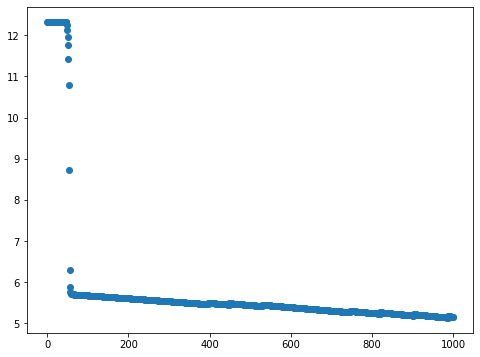

In [17]:
plt.figure(figsize = (8, 6))
plt.scatter(range(0, len(J)), J)
plt.show()

### Logistic Regression Performance 

#### Confusion Matrix

In [18]:
m = confusion_matrix(test_data, 'predict', 'Target')
m

,Positive,Negetive
Positive,12,82
Negetive,25,30


#### Accuracy

In [19]:
print("Accuracy for Logistic Regression algorithm %.3f" % accuracy(m))

Accuracy for Logistic Regression algorithm 0.282


#### Recall

In [20]:
print("Recall for Logistic Regression algorithm %.3f" %  recall(m))

Recall for Logistic Regression algorithm 0.324


#### F1_Score

In [21]:
print('F1_Score for Logistic Regression algorithm %.3f' %  f_score(1, m))

F1_Score for Logistic Regression algorithm 0.183


## ID3 Algorithm

In [22]:
def entropy(s):
    p = s.groupby('Target').size() / s.shape[0]
    ent = p*np.log2(p)
    return  -ent.sum()

In [23]:
def InformationGain(s, attribute):
    grouped = s.groupby(attribute)
    ig = grouped.size() / s.shape[0] * grouped.apply(lambda g : entropy(g))
    return entropy(s) - ig.sum()

In [24]:
def find_root(s):
    attributes = s.drop(['Target'], axis=1)
    return attributes.apply(lambda col: InformationGain(s, col)).idxmax()

In [25]:
def to_categorical(df):
    data = df.copy()
    for col in data.drop('Target', axis=1):
        cat=[]
        ig = -1
        for value in data[col].unique():
            if ((value>data[col].min()) and (value<data[col].max())):
                data['categorized'] = pd.cut(data[col], bins=[data[col].min()-1, value, data[col].max()], labels=[0,1])
                grouped = data.groupby('categorized')
                split_ig = InformationGain(data, 'categorized')
                if (ig<split_ig):
                    ig = split_ig
                    cat = data['categorized']
        data[col] = cat
    return data

In [26]:
def ID3(s, depth=150, tree=None):
    
    root = find_root(s)
    branches =s[root].unique()

    if tree is None:
        tree={}
        tree[root] = {}    
    
    for child in branches:
        split = s[s[root]==child]
        
        if((depth==1) or (s.shape[1]==1) or (len(split['Target'].unique())==1)):
            tree[root][child] = split.groupby('Target').size().idxmax()
            
        else:
            tree[root][child] = ID3(split, depth-1)
        
    return tree

In [27]:
def ID3_predict(data, tree, attribute, predict=list()):
    for key in tree[attribute].keys():
        if (type(tree[attribute][key]) == dict):
             ID3_predict(data[data[attribute]==key], tree[attribute][key], list(tree[attribute][key].keys())[0], predict)
        else:
            predict.append((data[data[attribute]==key].index, tree[attribute][key]))
    
    return predict

### Train and Test ID3 Model with Given Dataset

In [31]:
cat_df = to_categorical(df).drop('categorized', axis=1)
test_data, train_data = train_test(cat_df, 0.2)
decision_tree = ID3(train_data)
pred =[]
test_data['predict'] = 3
root = find_root(train_data)
pred = ID3_predict(test_data, decision_tree, root , pred)
for idx, label in pred:
    test_data.loc[idx, 'predict'] = label

### ID3 Performance

#### Confusion Matrix

In [32]:
m = confusion_matrix(test_data, 'predict', 'Target')
m

,Positive,Negetive
Positive,12,7
Negetive,25,105


#### Accuracy

In [33]:
print("Accuracy for ID3 algorithm %.3f" % accuracy(m))

Accuracy for ID3 algorithm 0.785


#### Recall

In [34]:
print("Recall for ID3 algorithm %.3f" % recall(m))

Recall for ID3 algorithm 0.324


#### F1_Score

In [35]:
print("F1_Score for ID3 algorithm %.3f" % f_score(1, m))

F1_Score for ID3 algorithm 0.429


## Improving Performance

### Optimized Linear Regresion Model Performance 

1. Normalize data
2. Change threshhold

In [49]:
def normalize(df):
    return (df - df.min())/(df.max() - df.min())

normalized_df = normalize(df)

In [50]:
normalized_df.head(3)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),Target
0,0.027027,1.000000,1.000000,1.000000,1.0
1,0.000000,0.244898,0.244898,0.270833,1.0
2,0.013514,0.306122,0.306122,0.343750,1.0


In [55]:
test_data, train_data = train_test(normalized_df, 0.2)
X = train_data.drop('Target', axis=1)
y = train_data['Target']
theta = [0.5]*len(X.columns)
test_data['predict'] = 3
J, theta = gradient_descent(X, y, theta, 1, 1000) 
pred=[]
pred = LR_predict(test_data.drop(['Target','predict'], axis=1), theta, 0.3)
test_data['predict'] = pred

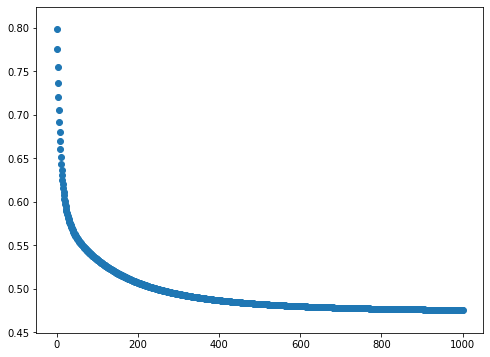

In [56]:
plt.figure(figsize = (8, 6))
plt.scatter(range(0, len(J)), J)
plt.show()

#### Confusion Matrix

In [57]:
m = confusion_matrix(test_data, 'predict', 'Target')
m

,Positive,Negetive
Positive,25,33
Negetive,12,79


#### Accuracy

In [58]:
print("Accuracy for ID3 algorithm", accuracy(m))

Accuracy for ID3 algorithm 0.697986577181208


#### Recall

In [59]:
print("Recall for ID3 algorithm", recall(m))

Recall for ID3 algorithm 0.6756756756756757


#### F1_Score

In [60]:
print("F1_Score for ID3 algorithm", f_score(1, m))

F1_Score for ID3 algorithm 0.5263157894736842


### Optimized ID3 Model Performance 

1. Limit max depth of tree

In [61]:
cat_df = to_categorical(df).drop('categorized', axis=1)
test_data, train_data = train_test(cat_df, 0.2)
decision_tree = ID3(train_data, 3)
pred =[]
test_data['predict'] = 3
root = find_root(train_data)
pred = ID3_predict(test_data, decision_tree, root , pred)
for idx, label in pred:
    test_data.loc[idx, 'predict'] = label

#### Confusion Matrix

In [62]:
m = confusion_matrix(test_data, 'predict', 'Target')
m

,Positive,Negetive
Positive,12,7
Negetive,25,105


#### Accuracy

In [63]:
print("Accuracy for ID3 algorithm %.3f" % accuracy(m))

Accuracy for ID3 algorithm 0.785


#### Recall

In [64]:
print("Recall for ID3 algorithm %.3f" % recall(m))

Recall for ID3 algorithm 0.324


#### F1_Score

In [94]:
print("F1_Score for ID3 algorithm %.3f" % f_score(1, m))

F2_Score for ID3 algorithm 0.359
